In [243]:
import iparser
import pandas as pd
import numpy as np
import importlib
import pickle
import spacy
import utils 
from tqdm.notebook import tqdm
from spacy.lang.en import English
from spacy.matcher import Matcher
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Топ профессий:

 

* Java разработчик/Software engineer
* Front-end разработчик/Web разработчик
* Продуктовый дизайнер
* Системный аналитик
* Архитектор систем
* Agile coach (под вопросом?)
* Data Scientist
* Data engineer
* Бизнес-аналитик
* Финансовый аналитик
* Кредитный аналитик
* Юрист (корпоративный, судебный)
* Маркетолог
 

 

# Используемый Подход 
* Парсер с определенной периодичностью запускается и соберает вакансии в базу
* Для анализа данные выгружаются из базы в датафрейм 


In [2]:
importlib.reload(iparser)
importlib.reload(utils)
pdict = utils.patterns_dict

In [3]:
vacancy_db = "vacancies.sqlite3"
import db_handler 
importlib.reload(db_handler)
db = db_handler.Db_handler(vacancy_db)
db.create_tab()

# for vaca in v.vacancies:
#     db.addvacancy(vaca)
# v_ids = [x[0] for x in db.show_vacancy_ids()]


cols = ['vacancy_id','description','profession','country','city','reqs','skills','date']
vtab = pd.DataFrame(db.show_vacancies(), columns=cols)

In [4]:
vtab.shape

(122603, 8)

In [5]:
vtab.head()

vacancy_id  \
0  /rc/clk?jk=8fb6adb20e0cc7c0&fccid=fe2d21eef233...   
1  /rc/clk?jk=66526d69241caf2c&fccid=48638adc9594...   
2  /rc/clk?jk=9d8e229307c5f80e&fccid=ec00141efcac...   
3  /rc/clk?jk=42f82312c8e47d82&fccid=319b94ac5d94...   
4  /rc/clk?jk=437873289bb297a9&fccid=8009d67e7070...   

                                         description   profession country  \
0  7+ years of relevant engineering experience3+ ...  Agile+coach      us   
1  Innovation, collaboration, and success: at OnD...  Agile+coach      us   
2  At the NBA, we’re passionate about growing and...  Agile+coach      us   
3  CLEAR's mission is to strengthen security and ...  Agile+coach      us   
4  Agile Coach Rock Star - hiring globally - (SO0...  Agile+coach      us   

       city reqs skills        date  
0  New+York              05-06-2020  
1  New+York              05-06-2020  
2  New+York              05-06-2020  
3  New+York              05-06-2020  
4  New+York              05-06-2020

In [6]:
profs = vtab.profession.unique()

In [10]:
# vtab.groupby(['profession'])['vacancy_id'].count().reset_index()

In [11]:
# vtab[vtab.profession == 'Data+engineer'].groupby(['profession','city'])['vacancy_id'].count().reset_index()

In [8]:
vacs_desc = vtab[vtab.profession == 'Data+Scientist']['description'].tolist()





In [18]:
# vacs_desc[11]

In [11]:
nlp = spacy.load('en_core_web_lg')
matcher = Matcher(nlp.vocab)
for k, el in pdict.items():
    matcher.add(k, None, el)

In [12]:
def requirements_extractor(doc, matcher=matcher):
    endpos = None
    matches = matcher(doc)
        
    if len(matches) > 0 :
        startpos = matches[0][1]
        for el in doc[startpos:]:
            if len(el.text.split("\n")) > 2 and (el.i) < len(doc):
#                 print(doc[el.i+1], el.i+1)
                endpos = el.i + 1
                break
    if endpos:
        return doc[startpos:endpos]
    else:
        return None
    

In [13]:
s = vacs_desc[6]
doc = nlp(s)
res = requirements_extractor(doc)

In [14]:
res

ideal candidate will have 5+ years of internal or external consulting data engineering experience, specifically in developing and structuring data for use in analysis pipelines. During this time, they will have demonstrated concrete evidence of success across the following 5 categories key to the success of their role.


In [242]:
reqs = []
for s in tqdm(vacs_desc):
    doc = nlp(s)
    res = requirements_extractor(doc)
    if res:
        if len(res) > 4:
#             print("_"*10)
#             print(res)
#             print(len(res))
            reqs.append(res.text)

In [246]:
def get_enteties_list(vtab, professions, max_ents=None):
    """ Создает список именованных сущностей """

    stop_labels = [
        "GPE",
        "ORG",
        "DATE",
        "CARDINAL",
        "LOC",
        "ORDINAL",
        "PERSON",
        "TIME",
        "LANGUAGE",
        "NORP", # Nationalities or religious or political groups.
        "FAC", # Buildings, airports, highways, bridges, etc.
        "EVENT", #Named hurricanes, battles, wars, sports events, etc.
        "PERCENT", #Percentage, including ”%“.
        "MONEY", #Monetary values, including unit.
        "QUANTITY", #Measurements, as of weight or distance.
    ]
    
    entsdict = {}
    for p in professions:
        term_prof = vtab.profession == p
        vacs_desc = vtab[term_prof]['description'].tolist() 
        entslist = []
        for s in tqdm(vacs_desc):
            doc = nlp(s)
            for ent in doc.ents:
                if ent.label_ not in stop_labels:
                    entslist.append((ent.text.strip('\n'), ent))
        if max_ents:
            if len(entslist)> max_ents:
                entslist = random.sample(entslist,max_ents)
        entsdict[p] = entslist
    
    return entsdict


In [248]:
professions = ['Data+Scientist']
ed = get_enteties_list(vtab, professions, max_ents=None)

In [ ]:
def get_matrix(entslist):
    """ Собирает матрицу векторов именованных сущностей и их названий """
    
    entsmx_vectors = []
    entsmx_name = []
    for el in entslist:
        if el[0] not in entsmx_name and el[1].has_vector:
            entsmx_vectors.append(el[1].vector)
            entsmx_name.append(el[0])
    entsmx = np.vstack(entsmx_vectors)
    return entsmx, entsmx_name

def get_cs_df(entsmx, entsmx_name):
    """ Формирует датафрейм из косинусного сходства"""
    
    cs = cosine_similarity(entsmx)
    csdf = pd.DataFrame(cs, columns=entsmx_name)
    csdf['tag'] = entsmx_name
    csdf = csdf.set_index('tag')
    return csdf


def get_similiarities_from_df(csdf):
    """Создает словарь сходств сущностей """
    
    simsdict = {}
    for col in tqdm(csdf.columns):
        simsdict[col] = dict(zip(csdf.index.tolist(),csdf[col].tolist()))
    return simsdict

# def get_similiarities(entslist):
#     entslist2 = [x[1] for x in entslist]
#     simsdict = {}
#     for e1 in tqdm(entslist2):
#         simtemp= {}
#         if e1.has_vector:
#             for e2 in entslist2:

#                 if e2.has_vector:
#                     simtemp[e2.text] = e1.similarity(e2)
#         simsdict[e1.text] = simtemp
#     return simsdict

def get_duplicates(simsdict,min_sim_score =0.7):
    """Формирует словарь дубликатов из сущностей с высоким сходством """
    
    tags = list(simsdict.keys())
    duplicates = {}
    for t in tags:
        items_sorted = sorted(simsdict[t].items(), key=lambda x:x[1], reverse=True)
        duplicates[t] = [x[0] for x in items_sorted if x[1] > min_sim_score]
    return duplicates

def get_frequencies(entslist, duplicates):
    """ Добавляет к словарю дубликатов частоту их встречаемости """
    
    c = Counter([x[0] for x in entslist])
    list_of_sets = [set([k,*v]) for k,v in duplicates.items()]
    unique_sets = []
    for el in list_of_sets:
        if el not in unique_sets:
            unique_sets.append(el)
    
    unique_sets_with_frequency = []
    for el in unique_sets:
        new_list = list(el)
        new_tup_list = [(x,c[x]) for x in new_list]
        new_tup_list = sorted(new_tup_list, key=lambda x:x[1], reverse=True)
        unique_sets_with_frequency.append(new_tup_list)
    return unique_sets_with_frequency

def get_duplicate_tags_dict(unique_sets_with_frequency):
    """Формирует словарь дубликатов из наиболее часто встречающихся"""
    
    dtags_dict = {}
    for elset in unique_sets_with_frequency:
        taglabel = None
        tag_total_frequency = sum([x[1] for x in elset])
        for i, t in enumerate(elset):
            if i == 0:
                taglabel = t[0]
            if taglabel:
                dtags_dict[t[0]] = [taglabel, tag_total_frequency]
    return dtags_dict

def get_frame(dtags_dict, min_frequency=None, ):
    """Формирует датафрейм названий сущностей и частоты их встречаемости"""
    
    newtags = []
    for k,v in dtags_dict.items():
        if v not in newtags:
            if v[0] not in stops:
                newtags.append(v)
                
    ftab = pd.DataFrame(newtags, columns=['tag', 'freq'])
    gtab = ftab.groupby('tag')['freq'].sum().reset_index().sort_values(by='freq', ascending=False)
    
    if min_frequency:
         gtab = gtab[gtab.freq > min_frequency].copy()
    return gtab

In [233]:
# i = 3
# print(entsmatrix_name[i])
# t1 = csdf[entsmatrix_name[i]] > 0.7
# csdf.loc[t1, entsmatrix_name[i]]

In [234]:
entsmx, entsmx_name = get_matrix(entslist)
csdf = get_cs_df(entsmx, entsmx_name)
simsdict = get_similiarities_from_df(csdf)

In [236]:
duplicates = get_duplicates(simsdict,min_sim_score =0.7)
unique_sets_with_frequency = get_frequencies(entslist, duplicates)
dtags_dict = get_duplicate_tags_dict(unique_sets_with_frequency)
df = get_frame(dtags_dict, min_frequency=None)

In [239]:
df.to_excel('sample.xlsx', index=False)

In [240]:
duplicates

{'Production\nManage': ['Production\nManage',
  'the Production Environment',
  'Production Support',
  'IT Production Support',
  'the Production Plan',
  'Management\nManage',
  'Description\nMonitor production',
  'Production Validation',
  'a Best Place to Work in Manufacturing and Production',
  'Branch\nExploration and Production',
  'the Production Part Approval Process',
  'Solutions\nAccount and Project Management',
  'Key Accountabilities Manage',
  'the Production Controller'],
 'JVM': ['JVM'],
 'J2EE': ['J2EE',
  'Java/J2EE',
  'J2EE/Java',
  'Oracle WebLogic Java',
  'EJB',
  'EJB 2.0/3.0'],
 'Virtual': ['Virtual',
  'Virtual Reality',
  'Virtual Instances',
  'Virtual Network',
  'Virtual and/or',
  'Virtual Infrastructure',
  'Virtual Desktop Infrastructure',
  'Virtual Private Cloud',
  'Virtual Network Configuration',
  'Check Point Virtual Firewalls and Virtual Systems',
  'Virtual Private Networks',
  'VMware virtual desktop infrastructure',
  'Virtual Private Databa

In [40]:
tags = list(simsdict.keys())

In [156]:
# sorted(simsdict['PhD'].items(), key=lambda x:x[1], reverse=True)

In [61]:
# set([1,3,4]) == set([1,4,3,4])

True

In [65]:
list_of_sets = [set([k,*v]) for k,v in duplicates.items()]

In [75]:
unique_sets = []
for el in list_of_sets:
    if el not in unique_sets:
        unique_sets.append(el)

In [81]:
unique_sets_with_frequency = []
for el in unique_sets:
    new_list = list(el)
    new_tup_list = [(x,c[x]) for x in new_list]
    new_tup_list = sorted(new_tup_list, key=lambda x:x[1], reverse=True)
    unique_sets_with_frequency.append(new_tup_list)

In [96]:
unique_sets_with_frequency[6]

[('Power BI', 9), ('Power BI Suite', 2), ('Microsoft Power BI', 1)]

In [86]:
sum([x[1] for x in unique_sets_with_frequency[2]])

356

In [91]:
dtags_dict = {}
for elset in unique_sets_with_frequency:
    taglabel = None
    tag_total_frequency = sum([x[1] for x in elset])
    for i, t in enumerate(elset):
        if i == 0:
            taglabel = t[0]
        if taglabel:
            dtags_dict[t[0]] = [taglabel, tag_total_frequency]
        
        

In [150]:
stops = ['A Place for Mom','Physical Requirements',
         'Financial Wellness for You” Learning Programs',
         'Ph.D.','Bachelor',"Master's","the Law",'Data Scientists'
        ]
newtags = []
for k,v in dtags_dict.items():
    if v not in newtags:
        if v[0] not in stops:
            newtags.append(v)

In [151]:
ftab = pd.DataFrame(newtags, columns=['tag', 'freq'])

gtab = ftab.groupby('tag')['freq'].sum().reset_index().sort_values(by='freq', ascending=False)

gtab[gtab.freq > 100]

In [155]:
# duplicates['Data Scientists']

tag  freq
0                               PhD in Computer Science   272
1     Bachelor's Degree in Engineering, Mathematics,...    93
2                                      Computer Science   479
3                                               the Law   187
4                                      Computer Science   537
...                                                 ...   ...
1121                                         navigation     1
1122                                        Cheson 2014     1
1123                                               ectd     1
1124                                                SOP     1
1125                                         Categories     1

[1126 rows x 2 columns]

In [44]:
duplicates = {}
min_sim_score = 0.7
for t in tags:
    items_sorted = sorted(simsdict[t].items(), key=lambda x:x[1], reverse=True)
    duplicates[t] = [x[0] for x in items_sorted if x[1] > min_sim_score]

0

In [50]:
duplicates['PhD\n']

['PhD',
 'Phd\n',
 'PhD\n\n',
 'PHD',
 'PhD\n',
 'PhD Degree',
 'PhD degree',
 'PhD Studies',
 'PhD Singapore',
 'PhD Preferred',
 'A PhD',
 "Master's/PhD",
 'Requirements\n\nPhD',
 'PhD/Masters',
 'Masters/PhD',
 'Masters / PhD',
 'PhD in Science',
 'PhD in Mathematics',
 'PhD - Quantitative',
 'Master/PhD',
 'Masters Degree or PhD',
 'MS/PhD',
 'PhD/MS',
 'PhD Computer Science',
 'PhD in Chemistry',
 'PhD Degree in Engineering']

In [ ]:
for k,v in 

In [42]:
duplicates

{'Master’s degree': ['PhD\n',
  'Phd\n',
  'PhD\n\n',
  'PHD',
  'PhD',
  'PhD Degree',
  'PhD degree',
  'PhD Studies',
  'PhD Singapore',
  'PhD Preferred',
  'A PhD',
  "Master's/PhD",
  'Requirements\n\nPhD',
  'PhD/Masters',
  'Masters/PhD',
  'Masters / PhD',
  'PhD in Science',
  'PhD in Mathematics',
  'PhD - Quantitative',
  'Master/PhD',
  'Masters Degree or PhD',
  'MS/PhD',
  'PhD/MS',
  'PhD Computer Science',
  'PhD in Chemistry',
  'PhD Degree in Engineering'],
 'Ph.D.': ['PhD\n',
  'Phd\n',
  'PhD\n\n',
  'PHD',
  'PhD',
  'PhD Degree',
  'PhD degree',
  'PhD Studies',
  'PhD Singapore',
  'PhD Preferred',
  'A PhD',
  "Master's/PhD",
  'Requirements\n\nPhD',
  'PhD/Masters',
  'Masters/PhD',
  'Masters / PhD',
  'PhD in Science',
  'PhD in Mathematics',
  'PhD - Quantitative',
  'Master/PhD',
  'Masters Degree or PhD',
  'MS/PhD',
  'PhD/MS',
  'PhD Computer Science',
  'PhD in Chemistry',
  'PhD Degree in Engineering'],
 'Excel': ['PhD\n',
  'Phd\n',
  'PhD\n\n',
  'P

In [38]:
ents_dict = {}
stop_labels = [
    "GPE",
    "ORG",
    "DATE",
    "CARDINAL",
    "LOC",
    "ORDINAL",
    "PERSON",
    "TIME",
    "LANGUAGE",
    "NORP", # Nationalities or religious or political groups.
    "FAC", # Buildings, airports, highways, bridges, etc.
    "EVENT", #Named hurricanes, battles, wars, sports events, etc.
    "PERCENT", #Percentage, including ”%“.
    "MONEY", #Monetary values, including unit.
    "QUANTITY", #Measurements, as of weight or distance.
]


reqentslist = []
for s in tqdm.notebook.tqdm(reqs):
    doc = nlp(s)
    for ent in doc.ents:
        if ent.label_ not in stop_labels:
            reqentslist.append(ent.text.strip())

c = Counter(reqentslist)
reqsentsorted = sorted(c.items(), key=lambda x:x[1], reverse=True)


In [44]:
# [x[0] for x in reqsentsorted]

In [189]:
# def get_vacancy_description(vtab, prof):
#     term_prof = vtab.profession == prof
#     vacs_desc = vtab[term_prof]['description'].tolist() 
#     return vacs_desc
     
# def ents_extractor(vacs_desc, stop_labels=stop_labels ):
#     entslist = []
#     for s in vacs_desc:
#         doc = nlp(s)
#         for ent in doc.ents:
#             if ent.label_ not in stop_labels:
#                 entslist.append(ent.text)
#     return entslist

# def ents_sorter(entslist):
#     c = Counter(entslist)
#     entsorted = sorted(c.items(), key=lambda x:x[1], reverse=True)
#     return entsorted  

# def combiner(prof,vtab=vtab, stop_labels=stop_labels):
#     vacs_desc = get_vacancy_description(vtab, prof)
#     ents = ents_extractor(vacs_desc, stop_labels=stop_labels)
#     entsorted = ents_sorter(entslist)
#     return entsorted

In [194]:
# entdict = {}
# for i,el in enumerate(profs):
#     entdict[el] = entzlist[i]

In [29]:
# s = " Deloitte "
# doc = nlp(s)
# stop_labels = [
#     "GPE",
#     "ORG",
#     "DATE",
#     "CARDINAL",
#     "LOC",
#     "ORDINAL"
#     "PERSON"
#     "TIME"
#     "LANGUAGE"
# ]
# for ent in doc.ents:
#     if ent.label_ not in stop_labels:
#         print(ent.text, ent.label_)

In [45]:
# with open('ent_texts_clean.pkl', 'rb') as f:
#     ed = pickle.load(f)

In [146]:
stoplist = [', excel',
'fortune 500',
'cellular',
'fortune 1000',
'build',
'requirements']

ed_stripped = {}
for k,v in ed.items():
    ed_stripped[k] = [(x[0].strip('\n').strip(" ").lower(),x[1]) for x in v]

# ed_stripped_new = {}
# for k, v in ed_stripped.items():
#     setlist = list(set([j[0] for j in v]))
#     for x in v:
#         if x[0] not in [j[0] for j in v]:
            

In [147]:
ed_stripped.keys()

dict_keys(['Agile+coach', 'Java+Developer', 'Software+engineer', 'Web+Developer', 'Front-end+Developer', 'Product+Designer', 'System+analyst', 'System+architect', 'Data+Scientist', 'Data+engineer', 'Business-analyst', 'Financial+analyst', 'Credit+analyst', 'Corporate+lawyer', 'Judicial+Lawyer', 'Marketing+Manager', 'Marketing+Specialist'])

In [91]:
# ed_stripped['System+analyst']

In [27]:
# with open('ent_texts_clean.pkl', 'wb') as f:
#     pickle.dump(ents_dict,f)

In [70]:
# df = pd.DataFrame(ed_stripped['System+analyst'], columns=['name', 'frequency'])
# df = df[df.frequency > 30]

In [180]:
def make_df(ed_stripped, keyword, n=30, stops=stops):
    
    tablist = ed_stripped[keyword]
    tablist = [x for x in tablist if x[0] not in stops]
    df = pd.DataFrame(tablist, columns=['name', 'frequency'])
    if n:
        df = df[df.frequency > n]
    return df

def make_barplot(df, keyword=""):
    sns.set(style="whitegrid")

    f, ax = plt.subplots(figsize=(6, 15))
    sns.set_color_codes("pastel")
    sns.barplot(x="frequency", y="name", data=df,
            label="frequency", color="b")
    
#     sns.countplot(y="name",label="frequency", data=df)

    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="",
       xlabel="Frequency", title=keyword)

    sns.despine(left=True, bottom=True)

def show_tags(ed_stripped, keyword, n=20):
    df = make_df(ed_stripped, keyword,n=n)
    make_barplot(df, keyword=keyword)

In [191]:
stops = ['fortune 500','playstation','instagram','the role',
         'apply', 'tesla', ', excel','fortune 500','cellular',
         'fortune 1000','build','requirements']

In [198]:
kw = []
sk = []
fr = []
for k,v in ed_stripped.items():
    for el in v:
        kw.append(k)
        sk.append(el[0])
        fr.append(el[1])

In [199]:
dfbig = pd.DataFrame({'keyword':kw, 'skill':sk, 'frequency':fr})

In [204]:
len(dfbig.skill.tolist())

75050

In [205]:
dfbig.skill.nunique()

40271

In [206]:
skills = dfbig.skill.unique().tolist()

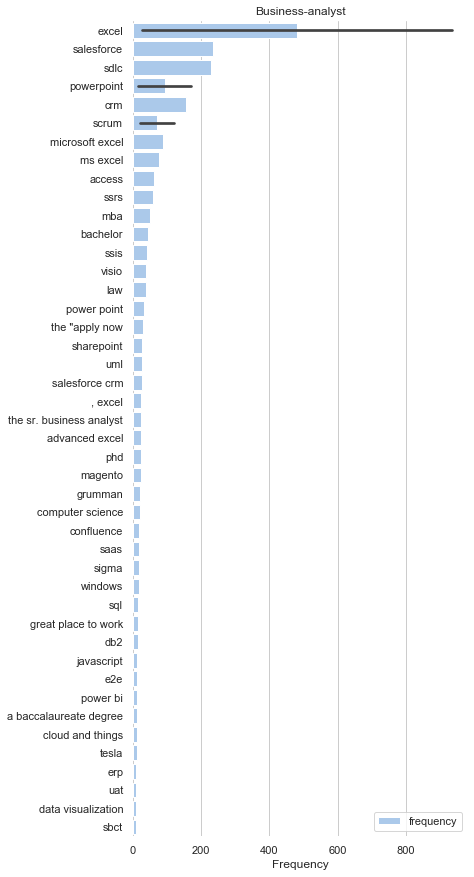

In [193]:
profs = list(ed_stripped.keys())
keyword= profs[10]
show_tags(ed_stripped, keyword,n=10)

In [183]:
smalllist = ['Agile+coach','Product+Designer','Financial+analyst', 'Credit+analyst', 
             'Corporate+lawyer', 'Judicial+Lawyer', 'Marketing+Manager', 'Marketing+Specialist']
with pd.ExcelWriter('profs.xlsx') as f:
    for k in ed_stripped.keys():
        n = 30
        if k in smalllist:
            n = 10
        df = make_df(ed_stripped, k, n=n)
        df.to_excel(f, sheet_name=k,index=False)
    

In [165]:
ed_stripped.keys()

dict_keys(['Agile+coach', 'Java+Developer', 'Software+engineer', 'Web+Developer', 'Front-end+Developer', 'Product+Designer', 'System+analyst', 'System+architect', 'Data+Scientist', 'Data+engineer', 'Business-analyst', 'Financial+analyst', 'Credit+analyst', 'Corporate+lawyer', 'Judicial+Lawyer', 'Marketing+Manager', 'Marketing+Specialist'])

In [99]:

# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="whitegrid")

# # Initialize the matplotlib figure
# f, ax = plt.subplots(figsize=(6, 15))

# # Load the example car crash dataset
# # crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# # Plot the total crashes
# sns.set_color_codes("pastel")
# sns.barplot(x="frequency", y="name", data=df,
#             label="frequency", color="b")

# # Add a legend and informative axis label
# ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(ylabel="",
#        xlabel="Frequency")
# sns.despine(left=True, bottom=True)

Data+Scientist


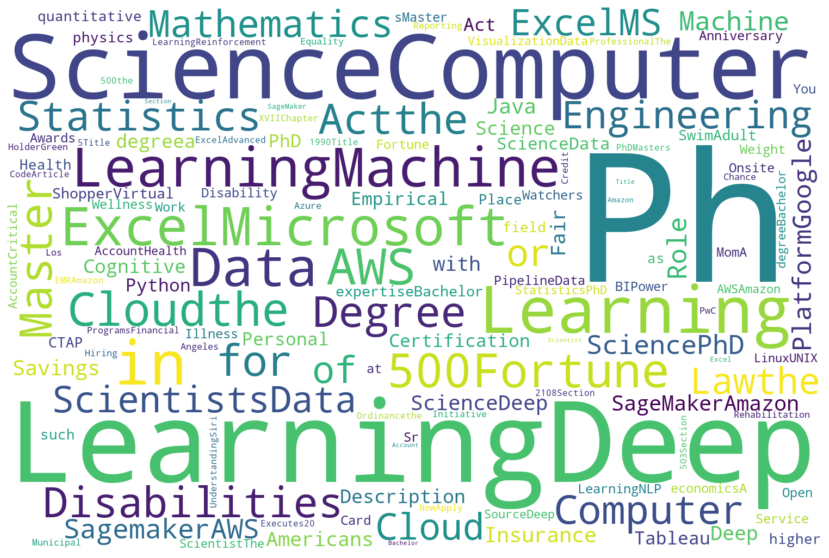

In [253]:
prof = 'Front-end+Developer'
# prof = 'Web+Developer'
prof = profs[8]
txtlist = []
entslist = ents_dict[prof]
# entslist = [e[0] for e in entslist]
# for ents in entslist:
#     txtlist = ents[0]
# #     txtlist.extend([x[0] for i in range(x[1]) if x[1] > 3])

newlist = []
for ent in entslist:
    if ent[1] > 5:
        entstr = ent[0] * ent[1]
        newlist.append(entstr)

# txtstr = ' '.join([e[0] for e in entslist])
txtstr = ', '.join(newlist)
print(prof)
# Create and generate a word cloud image:
stop_words = ['hour','billion', 'the', 'up', 'to','and','more than']
wordcloud = WordCloud(width=1500,
                      height=1000,
                      stopwords = stop_words,
                      background_color="white",
                      collocations=False
                     ).generate(txtstr)

# Display the generated image:
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [168]:
# wordcloud.words_

In [71]:
reqs_entslist = []
for s in tqdm.notebook.tqdm(reqs):
    doc = nlp(s)
    for ent in doc.ents:
        reqs_entslist.append(ent.text)

In [72]:
c = Counter(reqs_entslist)
reqs_entslistsorted = sorted(c.items(), key=lambda x:x[1], reverse=True)
reqs_entslistsorted

[('SQL', 42),
 ('Python', 26),
 ('Java', 20),
 ('Data Science', 20),
 ('PhD', 19),
 ('Computer Science', 18),
 ('one', 16),
 ('SAS', 15),
 ('AWS', 15),
 ('Excel', 13),
 ('5+ years', 12),
 ('NLP', 12),
 ('CitiusTech', 12),
 ('Deloitte', 11),
 ('thoughtware', 11),
 ('Deloitte Greenhouse', 11),
 ('ML', 11),
 ('US', 11),
 ('Tableau', 11),
 ('Hadoop', 10),
 ('ETL', 10),
 ('C++', 9),
 ('Scala', 9),
 ('3', 8),
 ('Apache Spark', 7),
 ('Big Data', 7),
 ('BS', 7),
 ('Industry Expansion and Relationship Building\nCollaborate Alliance', 6),
 ('EDW', 6),
 ('Azure', 6),
 ('two', 6),
 ('Linux', 6),
 ('Matlab', 6),
 ('PyTorch', 6),
 ('AI', 6),
 ('Clockwork', 6),
 ('Microsoft', 6),
 ('at least one', 6),
 ('four', 6),
 ('4) years', 6),
 ('Apply Now', 6),
 ('Industry Expansion and Relationship Building\n', 5),
 ('Analytics', 5),
 ('Kafka', 5),
 ('2+ years', 5),
 ('Data', 5),
 ('Annual', 5),
 ('4', 5),
 ('2', 5),
 ('GCP', 5),
 ('Healthcare', 5),
 ('Data Scientists', 5),
 ('Power BI', 5),
 ('Jam City', 5),

In [30]:
import re
s = reqs[43]
def hanmade_tokenizer(s):
    res = re.split(r"\n|;|,.",s)
    res = [x.strip() for x in res]
    res = [x for x in res if x not in ['']]
    return res

In [31]:
# re.split(r"\n|;|,.",s)
s = reqs[46]
hanmade_tokenizer(s)

['ideal candidate will have a strong grasp of software development fundamentals',
 'along with an interest in learning more about both new cutting-edge technologies and the Chemistry',
 'Biology',
 'and Physics problems that our software helps to solve.']

In [26]:
biglist = []
for s in reqs:
    res = hanmade_tokenizer(s)
    res = [x for x in res if x not in ['',' ']]
    biglist.extend(res)

In [27]:
txtdf = pd.DataFrame(biglist,columns=['text'])

In [28]:
import spacy #load spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger', 'ner'])
# stops = stopwords.words("english")
stops = spacy.lang.en.stop_words.STOP_WORDS

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


txtdf['norm_text'] = txtdf['text'].apply(normalize, lowercase=True, remove_stopwords=True)

In [29]:
norm_text = txtdf['norm_text'].tolist()
nlp = spacy.load('en_core_web_sm')
docs = []
for s in tqdm.tqdm_notebook(norm_text):
    docs.append(nlp(s))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [30]:
docs[10].vector.shape

(96,)

In [31]:
len(list(set(docs)))x

5210

In [32]:
nlp = spacy.load("en_core_web_lg")  # make sure to use larger model!

In [61]:
from sklearn.metrics.pairwise import cosine_similarity
cs = {}
bl = []
docs1 = []
docs2 = []
simsv = []
for doc1 in tqdm.tqdm_notebook(docs[:1000]):
    tres = {}
    for doc2 in docs[:1000]:
        try:
            r = cosine_similarity(doc1.vector.reshape(1, -1), doc2.vector.reshape(1, -1))
            if r > 0.85
                tres[doc2.text] = r[0][0]
                docs1.append(doc1)
                docs2.append(docs2)
                simsv.append(r[0][0])
        except ValueError :
            bl.append(doc2.text)
    
    cs[doc1] = tres

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [ ]:
simdf = pd.DataFrame({'itm1': docs1, 'itm2': docs2, 'score':simsv})

In [43]:
doc[100:500].ents

[Wells Fargo,
 Wholesale Banking,
 the United States,
 four,
 Corporate & Investment Banking,
 Commercial Banking,
 Commercial Real Estate,
 Wells Fargo Commercial Capital,
 the Wholesale Chief Operating Office,
 Algorithmic Trader,
 ATS,
 FX,
 Macro E-Platform,
 FX,
 FX,
 FX,
 FX,
 FX]

In [41]:
for c in doc.noun_chunks:
    print(c)

Important Note
the application process
your contact information
email
phone number
date
your current resume
your application
consideration
some selection activities
you
an invitation
The invitation
both email
text message
order
text message invitations
your profile
a mobile phone number
“Personal Cell
“Cellular
the contact information
your application
Wells Fargo
we
our customers’ financial needs
them
We
talented people
who
our customers
the center
everything
we
our diverse and inclusive team
you
your unique skills
experience
us
a better Wells Fargo
It
outstanding talent
It
you
Wholesale Banking
financial solutions
businesses
the United States
Our four major business lines
Corporate & Investment Banking
Commercial Banking
Commercial Real Estate
Wells Fargo Commercial Capital
We
groups
credit risk
group risk
finance
marketing
human relations
the Wholesale Chief Operating Office
our businesses
Successful candidate
the role
Algorithmic Trader
the Macro E-Trading Algorithmic Trading Strate

In [38]:
# with open('sims1k.pkl', 'wb') as f:
#     pickle.dump(cs,f)

In [ ]:
cs_new = {}
for k,v in cs.items():
    for kk,vv in v.items():
        tres = 
    

In [58]:
ks = list(cs.keys())[4]

In [59]:
ks
cs[ks]

{'ideal candidate 5 + year internal external consult datum engineer experience': 0.6898728,
 'specifically develope structure datum use analysis pipeline . time': 0.73864394,
 'demonstrate concrete evidence success follow 5 category key success role .': 0.74880385,
 'qualification': 0.525105,
 'bring establish sale method sale process': 1.0,
 'o develop organize differentiate market activity': 0.6894925,
 'o develop overview material support initial meeting / conversation': 0.8163768,
 'o lead preparation formal sale meeting oral qualify opportunity': 0.82511085,
 'o provide support core account cres need critical i&e opportunity': 0.68343294,
 'o identify opportunity ( sole source / bid ) bring business ( functional ) partner': 0.6198737,
 'evaluate opportunity alignment client strategy': 0.7287147,
 'o identify align appropriate firm resource pursue': 0.6335733,
 'win': 0.4055928,
 'manage opportunity': 0.7181171,
 'o lead pursuit process': 0.66413814,
 'rfp response': 0.6209146,
 'e

In [50]:
cs[ks]['product - drive technology team .'][0][0]

0.4051752

In [200]:

cosine_similarity(docs[1].vector.reshape(1, -1), docs[2].vector.reshape(1, -1))

array([[0.63597155]], dtype=float32)

array([[ 1.99165702e+00, -1.25236297e+00, -9.37911034e-01,
         6.58678293e-01, -9.05168653e-02,  1.07294381e-01,
         1.22539759e+00,  8.40529442e-01,  1.20618784e+00,
         1.96703482e+00,  3.16312003e+00, -1.70996904e-01,
         1.88429630e+00, -2.60295391e+00,  7.86821365e-01,
        -1.97734535e+00,  3.06851804e-01,  1.92688203e+00,
        -2.04203176e+00, -3.25758249e-01,  2.60205102e+00,
         8.58381838e-02, -5.75799465e-01, -7.81261802e-01,
        -2.31686926e+00, -1.53583968e+00, -5.89183509e-01,
        -2.64788318e+00,  2.89194918e+00, -3.24019361e+00,
         3.71261454e+00,  2.01283693e-01,  5.84064245e-01,
         7.13174164e-01,  1.84596241e-01, -1.82998288e+00,
         4.05095387e+00, -2.57433265e-01, -3.62787318e+00,
         5.13861835e-01,  4.78788424e+00, -4.78212059e-01,
         4.21033978e-01, -2.67334509e+00,  6.29396975e-01,
        -1.30750227e+00, -9.21405554e-02, -5.93005478e-01,
        -2.18722773e+00, -2.55334377e-03, -9.90116715e-0

In [154]:
tp = TextPreprocessor()

In [155]:
tp

TextPreprocessor(n_jobs=1, user_abbrevs={}, variety='BrE')

In [152]:
tp.fit(rawskills)

AttributeError: 'tuple' object has no attribute 'fit'

In [166]:
requirements_extractor(doc)

In [254]:
s = vacancy_dict['Data Scientist'][30]
doc = nlp(s)
# doc

In [121]:
matcher = Matcher(nlp.vocab)

pattern = [
    {'LEMMA':'requirement'},
    {'LEMMA':'skills'},
    {'LEMMA':'experience'},
]

In [122]:
for el in pdict.values():
    matcher.add('REQ_PATTERN', None, el)

In [150]:
# doc[502:]

In [116]:
c = 0
for el in doc[502:]:
    if len(el.text.split("\n")) > 2 and (el.i) < len(doc):
        print(doc[el.i+1], el.i+1)
        c = el.i + 1
        break


Accountabilities 600


In [124]:
doc[matches[0][1]:c]

Requirements:
A Finance/Economics/Business/Mathematics graduate
A demonstrated interest and knowledge in the financial markets
A proven record of outstanding achievement in academic and extracurricular activities
An independent thinker and decision maker who is able to contribute effectively to the team's success
Superior interpersonal and analytical skills
Ability to meet the challenges presented by a stressful, constantly changing work environment.
Ideally available to start asap – individual will be expected to go to Toronto for training 13th August for 2 wks.




